In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def load_hasoc_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    try: del data_df["text_id"]
    except: pass

    try: del data_df["task_2"]
    except: pass

    try: del data_df["task_3"]
    except: pass

    data_df.columns = ["text", "labels"]

    return data_df

def load_senti_news_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    data_df["text"] = data_df["content"]
    data_df["labels"] = data_df["avg_sentiment"].map(lambda x: "NOT" if round(float(x)) >= 3 else "HOF")

    data_df = data_df.drop(columns=set(data_df.columns) - {"text", "labels"})

    return data_df

def load_mmhs150k_dataset(path):
    df = pd.read_csv(path, keep_default_na=False)[["tweet", "label"]]
    df.columns = ["text", "labels"]
    df["labels"] = df["labels"].apply(lambda x: "NOT" if x == "NOT" else "HOF")
    return df

def read_redit_gab(path, slitter_re):
    data = []
    for i, row in tqdm(pd.read_csv(path).iterrows()):
       
        for s in slitter_re.findall(row["id"]):
            row["id"] = row["id"].replace(s, "<SEP>", 1)
            row["text"] = row["text"].replace(s, "<SEP>", 1)

        ids = [id.strip() for id in row["id"].split("<SEP>") if id.strip()]
        texts = [text.strip() for text in row["text"].split("<SEP>") if text.strip()]

        if len(ids) != len(texts):
            continue

        labels = row["hate_speech_idx"]
        labels = [] if labels is np.NaN else labels
        
        labels = ["HOF" if str(x+1) in labels else "NOT" for x in range(len(ids))]
        data += list(zip(texts, labels))

    return pd.DataFrame(data, columns=["text", "labels"])

In [3]:
hasoc_ml = pd.concat([
    load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/english/english_dataset/english_dataset.tsv"),
    load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/german/german_dataset/german_dataset.tsv"),
    load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/hindi/hindi_dataset/hindi_dataset.tsv"),
    load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/english/english_dataset/hasoc2019_en_test-2919.tsv"),
    load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/german/german_dataset/hasoc_de_test_gold.tsv"),
    load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/hindi/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv"),
])
redit_gab_en = pd.concat([
    read_redit_gab("data/non-processed/dataset14/reddit.csv",  re.compile("(\d+\. [\\t]*)[a-z0-9]{7}\\n")),
    read_redit_gab("data/non-processed/dataset14/gab.csv",     re.compile("(\d+\. [\\t]*)[0-9]{8}\\n"))
])
sentinews_si = load_senti_news_dataset("data/non-processed/dataset10/SentiNews_sentence-level.txt")
mmhs150k = load_mmhs150k_dataset("data/non-processed/dataset12/MMHS150K.csv")

5020it [00:01, 4501.76it/s]
11825it [00:02, 5548.60it/s]


In [4]:
def plot_class_hist(data_df, title, ax):
    data_df["labels"].value_counts().plot(kind="bar", title=f"{title}", ax=ax)

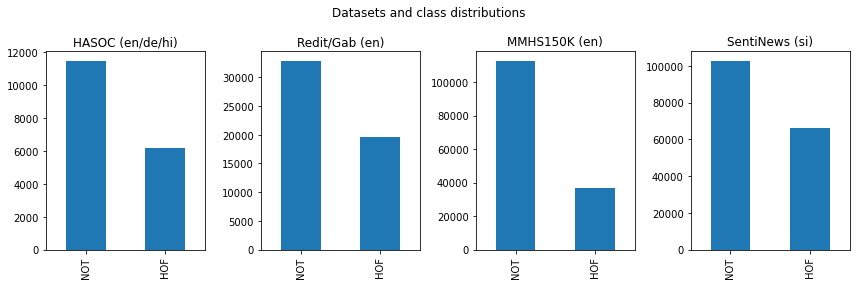

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(12, 4)
fig.suptitle('Datasets and class distributions')
plot_class_hist(hasoc_ml, "HASOC (en/de/hi)", ax1)
plot_class_hist(redit_gab_en, "Redit/Gab (en)", ax2)
plot_class_hist(mmhs150k, "MMHS150K (en)", ax3)
plot_class_hist(sentinews_si, "SentiNews (si)", ax4)
fig.tight_layout()
fig.savefig("results/dataset_distributions_simplified.pdf")

In [6]:
%reset